<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/Notebooks/BAF_exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries

In [2]:
#!git clone https://github.com/MDankloff/Cluster-Bias-Disco.git
#!cd Cluster-Bias-Disco/
from google.colab import drive
drive.mount('/content/drive')
! cd '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dask[dataframe]

In [9]:
import pickle
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import glob
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

# Load data and Best LightGBM Models

In [36]:
base_path = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/parquet data'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [34]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

In [33]:
# directory containing the model files
model_dir = '/content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant'

# Get list of all model files in the directory
model_files = glob.glob(os.path.join(model_dir, '*.pkl'))

# Dictionary to store loaded models
models = {}

# Load all models from the directory and save them to the dictionary
for model_file in model_files:
    # Load the model
    with open(model_file, 'rb') as f:
        model = joblib.load(f)

    # Extract the model name from the file path (without extension)
    model_name = os.path.basename(model_file).split('.')[0]

    # Add the model to the dictionary
    models[model_name] = model

    # Optional: Save the model back (though it seems redundant here)
    save_path = os.path.join(model_dir, f'{model_name}.pkl')
    joblib.dump(model, save_path)

    print(f"Model '{model_name}' loaded and saved to: {save_path}")

# Accessing the best model per variant
modelb = models.get("model_Base_top_4")
modelv1 = models.get("model_Variant I_top_4")
modelv2 = models.get("model_Variant II_top_4")
modelv3 = models.get("model_Variant III_top_0")
modelv4 = models.get("model_Variant IV_top_6")
modelv5 = models.get("model_Variant V_top_0")

Model 'model_Base_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Base_top_4.pkl
Model 'model_Variant II_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant II_top_4.pkl
Model 'model_Variant III_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant III_top_0.pkl
Model 'model_Variant IV_top_6' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant IV_top_6.pkl
Model 'model_Variant V_top_0' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant V_top_0.pkl
Model 'model_Variant I_top_4' loaded and saved to: /content/drive/MyDrive/Mirthe_Supervision /Paper#3/BAF/Best Model per Variant/model_Variant I_top_4.pkl


# Pre-process

In [37]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      0 non-null        float64
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [54]:
train_dfs = {key: df[df["month"] < 6].sample(frac=1, replace=False) for key, df in dataframes.items()}
test_dfs = {key: df[df["month"] >= 6].sample(frac=1, replace=False) for key, df in dataframes.items()}

In [55]:
def convert_object_to_num(data):
    for column in data.select_dtypes(include=['object']).columns:
        # Convert object to boolean if the values are binary (0/1)
        if data[column].isin([0, 1]).all():  # Checks if the column contains only 0s and 1s
            data[column] = data[column].astype(bool)  # Convert to boolean (True/False)

        # Otherwise, convert to numeric (int or float)
        else:
            try:
                data[column] = pd.to_numeric(data[column], errors='raise', downcast='integer')
            except ValueError:
                # If conversion fails to int, try float
                try:
                    data[column] = pd.to_numeric(data[column], errors='raise', downcast='float')
                except ValueError:
                    # If numeric conversion fails, coerce errors to NaN (handle invalid strings)
                    data[column] = pd.to_numeric(data[column], errors='coerce')
    return data

In [60]:
base_df_cleaned = convert_object_to_num(test_dfs['Base'])
variant1_df_cleaned = convert_object_to_num(test_dfs['Variant I'])
variant2_df_cleaned = convert_object_to_num(test_dfs['Variant II'])
variant3_df_cleaned = convert_object_to_num(test_dfs['Variant III'])
variant4_df_cleaned = convert_object_to_num(test_dfs['Variant IV'])
variant5_df_cleaned = convert_object_to_num(test_dfs['Variant V'])
#base_df_cleaned.info()

# Get the Errors

In [43]:
def get_errors (model, data, test_dfs):
    """
    Evaluate trained model on test data and compute metrics and errors.
    - model: Trained model (Best LightGBM model)
    - X_test: Feature matrix for the test data
    - Y_test: True labels for the test data

    Returns:
    - metrics: Dictionary containing calculated metrics (accuracy, precision, recall, f1, ROC AUC)
    - predictions: DataFrame containing the true and predicted classes along with errors
    """
    #get test data
    X_test = test_dfs[data].drop(columns=["fraud_bool"])
    Y_test = test_dfs[data]["fraud_bool"]

    #predict
    Y_pred = model.predict(X_test)
    Y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC (for class 1)

    # Convert predictions and true labels to integers if they are not already
    Y_pred = Y_pred.astype(int)  # Ensure predictions are integers (0 or 1)
    Y_test = Y_test.astype(int)  # Ensure true labels are integers (0 or 1)

   #get evaluation metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_prob)

    #Print the evaluation metrics & confusion matrix
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    #get errors
    predictions = pd.DataFrame()
    predictions['predicted_class'] = Y_pred.tolist()  # Convert np.array to list if needed
    predictions = predictions.set_index(X_test.index)  # Set index to match X_test
    predictions['true_class'] = Y_test  # Add true classes

    #Calculate the errors by taking the absolute difference
    predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])

    return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc
    }, predictions

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Accuracy: 0.9860
Precision: 0.6667
Recall: 0.0007
F1-Score: 0.0014
ROC AUC: 0.8517
Confusion Matrix:
[[202132      1]
 [  2876      2]]


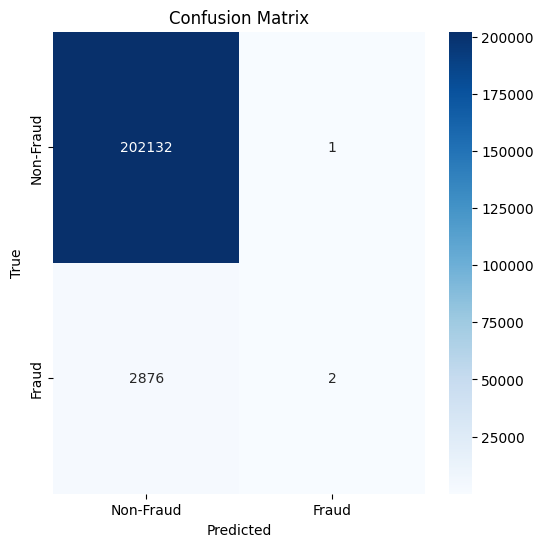

({'accuracy': 0.985966606669886,
  'precision': 0.6666666666666666,
  'recall': 0.0006949270326615705,
  'f1': 0.0013884068031933356,
  'roc_auc': 0.8516971846198444},
         predicted_class  true_class  errors
 977566                0           0       0
 961165                0           0       0
 934581                0           0       0
 962124                0           0       0
 799429                0           0       0
 ...                 ...         ...     ...
 831573                0           0       0
 830588                0           0       0
 881488                0           0       0
 846422                0           0       0
 912698                0           0       0
 
 [205011 rows x 3 columns])

In [57]:
get_errors(modelb, 'Base', test_dfs)